In [337]:
%load_ext autoreload
%autoreload 2
from utils import *
from IPython.display import display, HTML
ins = BrainSpan()
mpl.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Columns Meta Data
bp_exon_col_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/columns_metadata.csv", delimiter=",")
bp_exon_col_meta.age.unique()
bp_exon_col_meta["Period"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[0], axis=1)
bp_exon_col_meta["Stage"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[1], axis=1)
bp_exon_col_meta["Description"] = bp_exon_col_meta.apply(lambda row: ins.TemporalMap(row["age"])[2], axis=1)
#print bp_exon_col_meta.shape
display(bp_exon_col_meta.head(2)) 
#print "Sample size", pd.unique(bp_exon_col_meta.donor_id).size
#print "Periods:",bp_exon_col_meta.drop_duplicates("donor_id").groupby("Period")["Period"].count()
strcture_count = bp_exon_col_meta.groupby("structure_acronym")["structure_acronym"].count()
Regions = bp_exon_col_meta.drop_duplicates("structure_acronym")[["structure_id","structure_acronym","structure_name"]]
Regions["sample count"] = Regions.apply(lambda row: strcture_count[row["structure_acronym"]], axis=1)
Regions.to_excel("../data/expression/brainspan/exons_matrix/Regions.xlsx", index=False)
# Rows Meta Data
bp_exon_row_meta = pd.read_csv(
    "/Users/jiayao/Work/BrainDisorders/data/expression/brainspan/exons_matrix/rows_metadata.csv", delimiter=",")
bp_exon_row_meta["exon length"] = bp_exon_row_meta["end"] - bp_exon_row_meta["start"]
display(bp_exon_row_meta.head(2))

,column_num,donor_id,donor_name,age,gender,structure_id,structure_acronym,structure_name,Period,Stage,Description
0,1,13058,H376.IIA.51,8 pcw,M,10665,URL,upper (rostral) rhombic lip,2A,2,Early prenatal
1,2,13058,H376.IIA.51,8 pcw,M,10194,OFC,orbital frontal cortex,2A,2,Early prenatal


,row_num,gene_id,ensembl_gene_id,gene_symbol,entrez_id,start,end,exon length
0,1,1086864,ENSG00000000003,TSPAN6,7105.0,99883666,99884983,1317
1,2,1086864,ENSG00000000003,TSPAN6,7105.0,99885755,99885863,108


In [383]:
MisVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014ProMIS.xlsx"
mis_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, MisVarFile, IntersectionWithPredicted=True)
bp_exon_row_meta_mis_with_gene = mis_annotated_exon_row_meta[mis_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_mis_with_gene.to_excel("GenesExonsTargetedByMIS.xlsx", index=False)
bp_exon_row_meta_mis_with_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]!=""]
bp_exon_row_meta_mis_without_var = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["Vars"]==""]
print bp_exon_row_meta_mis_with_gene.shape, bp_exon_row_meta_mis_with_var.shape, bp_exon_row_meta_mis_without_var.shape

309222(570, 15) (30, 15) (540, 15)


In [384]:
mis_expdict = ins.LoadGeneSetDataFromFil("ProbandMIS.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_mis_with_gene["gene_symbol"].values))
probandMIS = GeneExonSet(mis_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_mis_with_gene[bp_exon_row_meta_mis_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    probandMIS.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
print len(probandMIS.genes), len(probandMIS.TargetedExon),len(probandMIS.UntargetedExon)

23 30 540


In [317]:
#print sorted(T)

In [325]:
TTseq, TTerr, UUseq, UUerr = probandLGD.Reduce(logscale=True)
N = 100 * 10
biases = []
for i in xrange(N):
    Tseq, Useq = [], []
    for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
        if np.isnan(mu1):
            continue
        s1 = np.random.normal(mu1, sig1)
        s2 = np.random.normal(mu2, sig2)
        Tseq.append(2**(s1))
        Useq.append(2**(s2))
    pre, post , bias= Bias(Tseq, Useq)
    biases.append(bias)
print np.mean(biases), math.sqrt(np.var(biases))

11.0446464576 0.613954872926


proband LGD 1.52982651193 1.40017926652 1.09259331895
proband Mis 1.58906311543 1.42925652491 1.11181099246


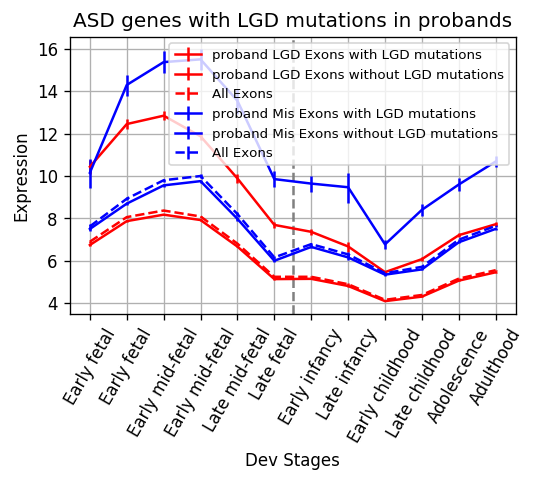

In [444]:
prolgd = probandLGD.Reduce(logscale=False)
promis = probandMIS.Reduce(logscale=False)
fig, ax = plt.subplots(figsize=(6, 3), dpi=120)
plt.title("ASD genes with LGD mutations in probands")
for title, color, Dat in [("proband LGD", 'red', prolgd),("proband Mis", 'blue', promis)]:
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat

    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title +" Exons with LGD mutations", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, label=title+" Exons without LGD mutations", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label="All Exons", color=color)
    pre, post, bias = Bias(Tseq, Useq)
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
#plt.ylim(3.75,14.25)
plt.show()

proband LGD 1.09074899037 0.998311971575 1.09259331895


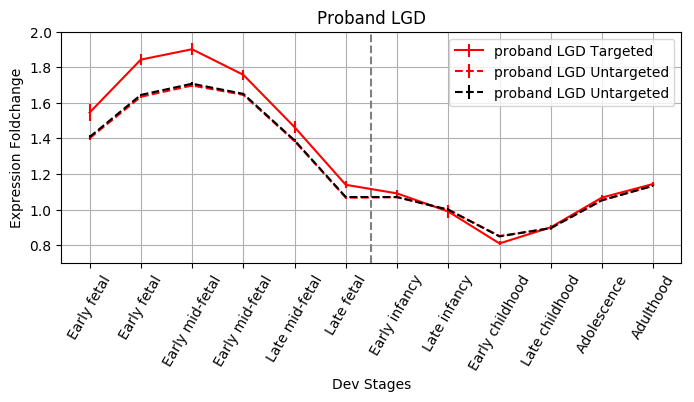

In [408]:
prolgd = probandLGD.Reduce(logscale=False)
promis = probandMIS.Reduce(logscale=False)
fig, ax = plt.subplots(figsize=(10, 3))
plt.title("Proband LGD")
#for title, color, Dat in [("proband LGD", 'red', prolgd), ("proband MIS", 'blue', promis)]:
for title, color, Dat in [("proband LGD", 'red', prolgd)]:
    Tseq, Terr, Useq, Uerr, All, Allerr = Dat
    Tseq_mean, Useq_mean = np.mean(Tseq[6:13]), np.mean(Useq[6:13])
    Aseq_mean = np.mean(All[6:13])
    Tseq = [x/Tseq_mean for x in Tseq]
    Useq = [x/Useq_mean for x in Useq]
    Terr = [x/Tseq_mean for x in Terr]
    Uerr = [x/Useq_mean for x in Uerr]
    All = [x/Aseq_mean for x in All]
    Allerr = [x/Aseq_mean for x in Allerr]
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    ax.errorbar(range(2,14), All, yerr = Allerr, linestyle = '--', label=title+" Untargeted", color='black')
    pre, post, bias = Bias(Tseq, Useq)
    print title, pre, post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right')
plt.xlabel("Dev Stages")
plt.ylabel("Expression Foldchange")
plt.ylim(0.7,2.0)
plt.show()

WilcoxonResult(statistic=1155.0, pvalue=0.00012731579257084993)


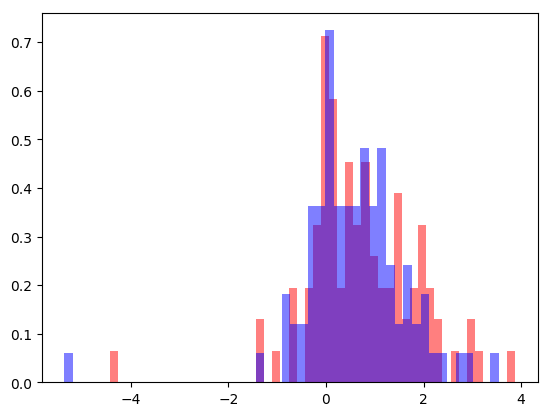

In [299]:
Pre, Post = probandLGD.wilcoxonTest()
diff = [(x-y) for x,y in zip(Pre, Post)]
diff = [x for x in diff if str(x) != 'nan']
pre = [x for x in Pre if str(x) != 'nan']
post = [x for x in Post if str(x) != 'nan']
from scipy.stats import wilcoxon
print wilcoxon(pre, post)
bins = [x*0.1 for x in xrange(-50,50)]
plt.hist(pre, 50, color="red", normed=1, alpha=0.5)
plt.hist(post, 50, color="blue", normed=1, alpha=0.5)
plt.show()

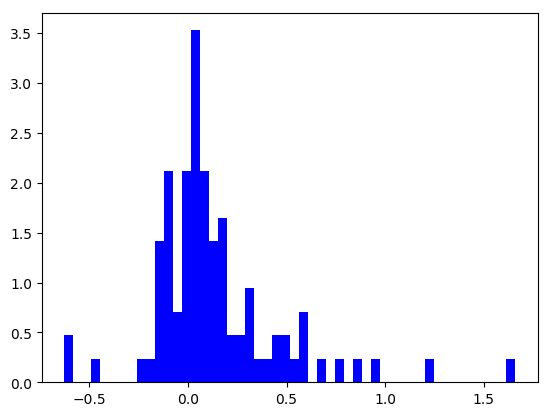

0.132383575042


In [267]:
bins = [x*0.1 for x in xrange(-20,20)]
plt.hist(diff, 50, color="blue", normed=1)
plt.show()
print np.mean(diff)

17.5733375967 21.2740144406 -3.7006768439


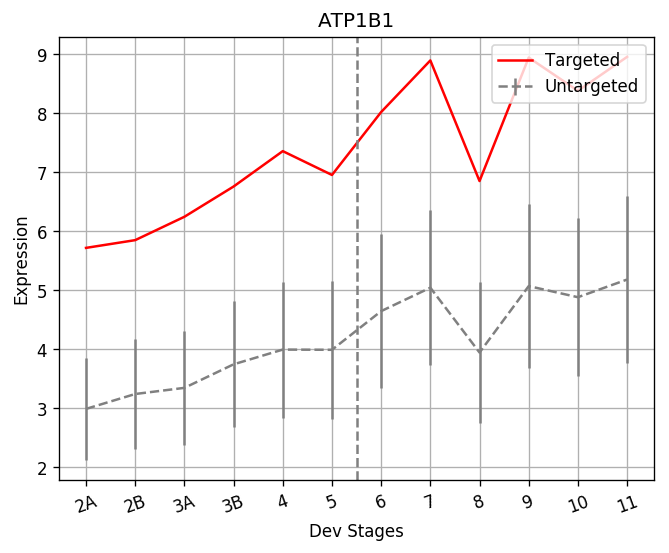

[119896]
3.30197143133 3.4403660473 -0.138394615968


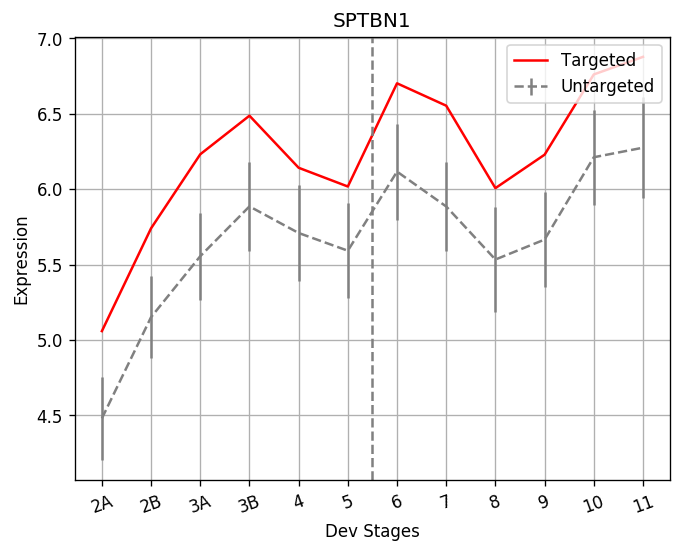

In [262]:
probandLGD.Genes["ATP1B1"].plot(probandLGD.expdict)
print probandLGD.Genes["ATP1B1"].TargetedExons
probandLGD.Genes["SPTBN1"].plot(probandLGD.expdict)

In [ ]:
def lengthdis(SET1, SET2, dat):
    list1 = dat[dat["row_num"].isin(SET1)]["exon length"].values
    list2 = dat[dat["row_num"].isin(SET2)]["exon length"].values
    bins = [x*0.1 for x in xrange(100)]
    plt.hist([math.log(x, 10) for x in list1], bins=bins, normed=1)
    plt.hist([math.log(x, 10) for x in list2 if x !=0], alpha = 0.2, bins=bins, normed=1)
    plt.xlim(0, 4.5)
    plt.show()
T = []
N = 10000
for i in xrange(N):
    bias, TE, UE = probandLGD.Permute(plot=False)
    T.append(bias)
    #lengthdis(TE, UE, bp_exon_row_meta)

In [365]:
def lengthdis(SET1, SET2, dat):
    list1 = dat[dat["row_num"].isin(SET1)]["exon length"].values
    list2 = dat[dat["row_num"].isin(SET2)]["exon length"].values
    bins = [x*0.1 for x in xrange(100)]
    plt.hist([math.log(x, 10) for x in list1], bins=bins, normed=1)
    plt.hist([math.log(x, 10) for x in list2 if x !=0], alpha = 0.2, bins=bins, normed=1)
    plt.xlim(0, 4.5)
    plt.show()
T = []
N = 100
for i in xrange(N):
    bias, TE, UE = probandLGD.Permute(plot=False)
    T.append(bias)
    #lengthdis(TE, UE, bp_exon_row_meta)

[1.0072144571626283, 1.0082033315745316, 1.0089720500435286, 1.0095743406682316, 1.0101677850494488, 1.0106399723067541, 1.0169403979573755, 1.0212223244168668, 1.0235470695976199, 1.0351236709236851]
0.01


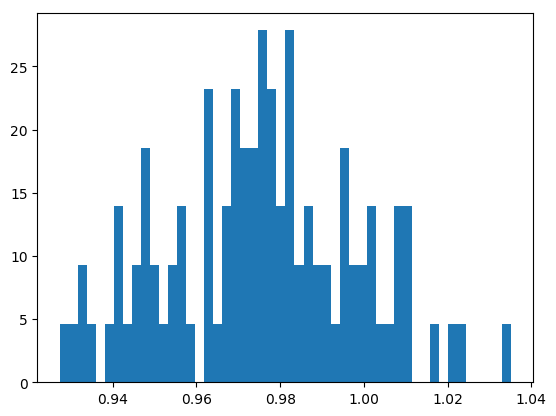

In [366]:
from scipy.stats import norm
bins = [x*0.1 for x in range(-100, 100)]
plt.hist(T,50, normed=1)
#plt.hist(T)
#T_obs = 0.766156518416
T_obs = 11.0335670848

T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print float(N-i)/N

#mu, std = norm.fit(T)
#print mu, std
#xmin, xmax = plt.xlim()
#x = np.linspace(mu - 3*std, mu + 3*std, 100)
#p = norm.pdf(x, mu, std)
#plt.plot(x, p, 'k', linewidth=2)
#title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
#plt.title(title)
#print norm.sf(T_obs, mu, std)
plt.show()

# Function Categ

In [338]:
cates = []
color=["red", "blue", "purple", "green"]
for i,func in enumerate(["Chromatin", "Channel&PSD", "Cytp&Sig", "TF&RBP"]):
    GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains(func)]
    #print GeneDF.head(2)
    Genes = list(set(GeneDF["gene_symbol"].values))
    tmp = GeneExonSet(expdict, func, color[i])
    for i, gene in enumerate(Genes):
        #print gene
        gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
        TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
        UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
        #print TargetedExon
        TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
        UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
        tmp.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
    cates.append(tmp)

In [342]:
for i in range(4) :
    TTseq, TTerr, UUseq, UUerr = cates[i].Reduce(logscale=True)
    N = 100 * 10
    biases = []
    for i in xrange(N):
        Tseq, Useq = [], []
        for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
            if np.isnan(mu1):
                continue
            s1 = np.random.normal(mu1, sig1)
            s2 = np.random.normal(mu2, sig2)
            Tseq.append(2**(s1))
            Useq.append(2**(s2))
        pre, post , bias= Bias(Tseq, Useq)
        biases.append(bias)
    print np.mean(biases), math.sqrt(np.var(biases))

11.4440089813 1.0715807557
9.12155875437 1.22152334874
6.26424615779 2.15493925638
43.6513350334 2.82578900528


In [65]:
print cates[2].genes
print cates[3].genes

['NEDD9', 'CDC42BPB', 'EIF2AK2', 'DSCAML1', 'SYNGAP1', 'GOLGA5', 'NMT1', 'L1CAM', 'DYRK1A', 'DSCAM', 'SPTBN1', 'PDCD1']
['PHF21A', 'IRF2BPL', 'LTN1', 'ZMYND11', 'KAT6A', 'PHF2', 'PHF3']


Chromatin 1.59340666215 1.48775249152 0.105654170634 1.07101595947
Channel&PSD 1.61346104919 1.50881040325 0.104650645936 1.06935970597
Cytp&Sig 1.11626360088 1.01818451468 0.0980790861995 1.09632741884
TF&RBP 2.66198027222 2.0797721252 0.582208147023 1.2799384317


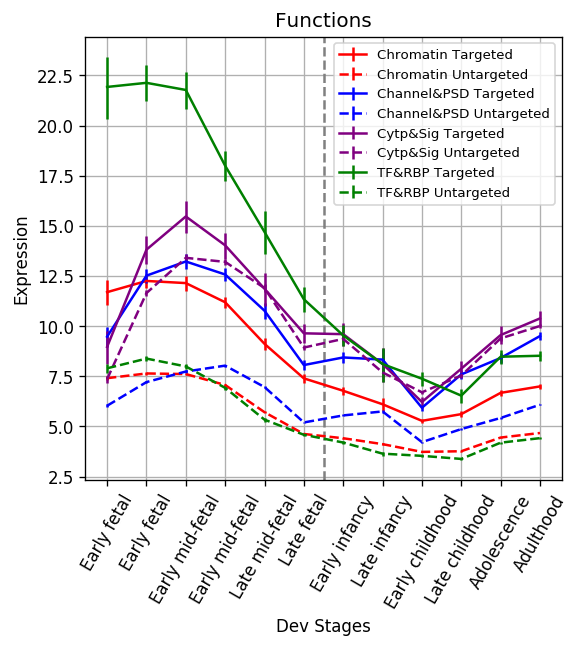

In [390]:
fig, ax = plt.subplots(dpi=120)
plt.title("Functions")
for cate in cates:
    Tseq, Terr, Useq, Uerr = cate.Reduce()
    #print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post,bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle='--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

Chromatin 1.02591123226 0.95788603633 0.0680251959296 1.07101595947
Channel&PSD 1.02629135977 0.959725108437 0.0665662513344 1.06935970597
Cytp&Sig 1.04155270432 0.950037996335 0.0915147079843 1.09632741884
TF&RBP 1.08303678698 0.846163190475 0.236873596504 1.2799384317


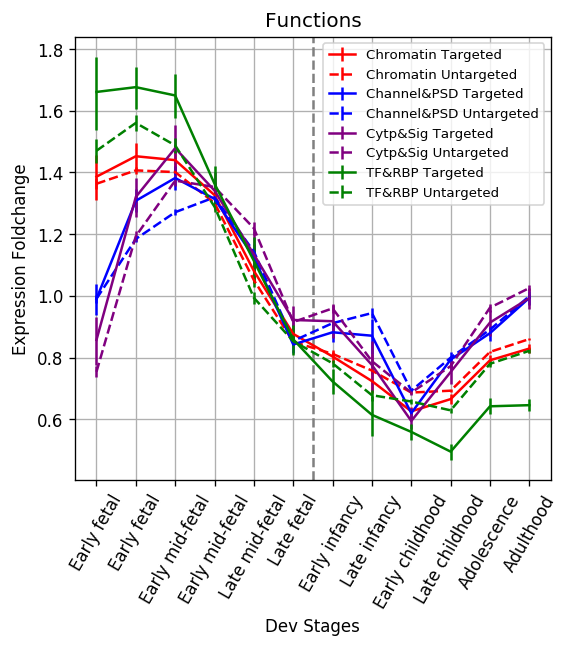

In [389]:
fig, ax = plt.subplots(dpi=120)
plt.title("Functions")
for cate in cates:
    Tseq, Terr, Useq, Uerr = cate.Reduce()
    Tseq_mean, Useq_mean = np.mean(Tseq), np.mean(Useq)
    Tseq = [x/Tseq_mean for x in Tseq]
    Useq = [x/Useq_mean for x in Useq]
    Terr = [x/Tseq_mean for x in Terr]
    Uerr = [x/Useq_mean for x in Uerr]
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post,bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle='--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression Foldchange")
plt.show()

In [15]:
GeneDF1 = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains("Chromatin") | 
                                       bp_exon_row_meta_with_gene.Func.str.contains("TF&RBP")]
Genes1 = list(set(GeneDF1["gene_symbol"].values))
DEVEL = GeneExonSet(expdict, "DEVEL", "red")
for i, gene in enumerate(Genes1):
    gene_df = GeneDF1[GeneDF1["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    DEVEL.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)

GeneDF2 = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene.Func.str.contains("Channel&PSD") | 
                                       bp_exon_row_meta_with_gene.Func.str.contains("Cytp&Sig")]
Genes2 = list(set(GeneDF2["gene_symbol"].values))
NEURO = GeneExonSet(expdict, "NEURO", "blue")
for i, gene in enumerate(Genes2):
    gene_df = GeneDF2[GeneDF2["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonLength = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonLength = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    NEURO.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)    

In [343]:
for cat in [DEVEL, NEURO] :
    TTseq, TTerr, UUseq, UUerr = cat.Reduce(logscale=True)
    N = 100 * 10
    biases = []
    for i in xrange(N):
        Tseq, Useq = [], []
        for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
            if np.isnan(mu1):
                continue
            s1 = np.random.normal(mu1, sig1)
            s2 = np.random.normal(mu2, sig2)
            Tseq.append(2**(s1))
            Useq.append(2**(s2))
        pre, post , bias= Bias(Tseq, Useq)
        biases.append(bias)
    print np.mean(biases), math.sqrt(np.var(biases))

14.8447843462 0.991824055873
8.71980806026 1.08417165809


55
[12.81169557099588, 13.351077439918628, 13.220599047606317, 11.98905411630264, 9.7707555059182738, 7.8677400687137835, 7.1203445082453474, 6.3604229251946984, 5.5396585642275342, 5.736209951739756, 6.907269186604438, 7.1961543429677288]
DEVEL 1.71686341465 1.56108994578 0.155773468874 1.09978506959
54
[9.3291605271427827, 12.862261480273851, 13.81014383922127, 12.960844472234086, 11.060616068125752, 8.4688614813610616, 8.7443373559838946, 8.2690586263327752, 6.0068238240010228, 7.6690626325003333, 8.7127036710705195, 9.7400411898198644]
NEURO 1.47390549226 1.36889108516 0.105014407103 1.07671494704


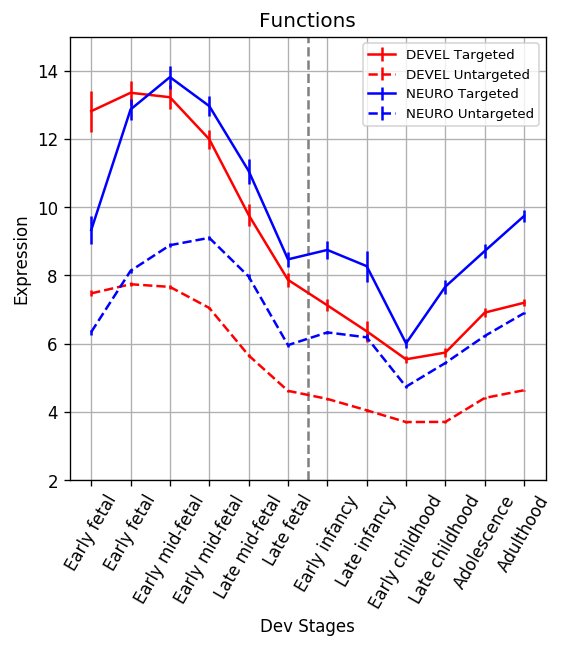

In [391]:
fig, ax = plt.subplots(dpi=120)
plt.title("Functions")
for cate in [DEVEL, NEURO]:
    print len(cate.TargetedExon)
    Tseq, Terr, Useq, Uerr = cate.Reduce()
    print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.ylim(2,15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

55
DEVEL 1.0984881728 0.998820772505 0.0996674002911 1.09978506959
54
NEURO 1.07347807198 0.9969937493 0.0764843226775 1.07671494704


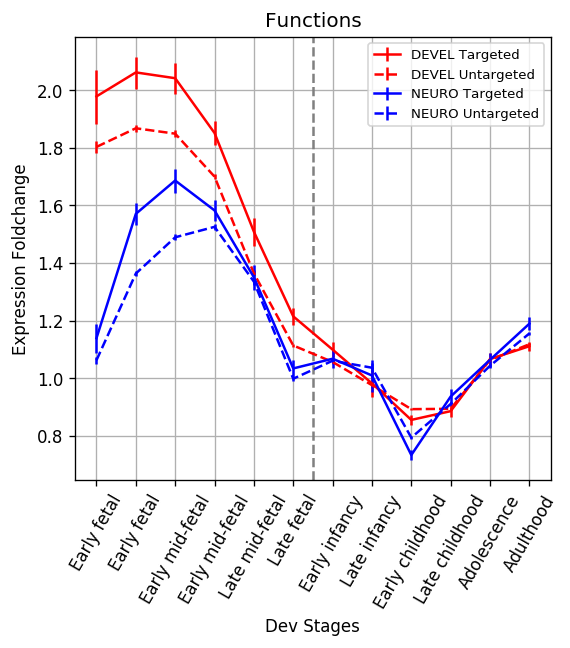

In [438]:
fig, ax = plt.subplots(dpi=120)
plt.title("Functions")
for cate in [DEVEL, NEURO]:
    print len(cate.TargetedExon)
    Tseq, Terr, Useq, Uerr, All, Allerr = cate.Reduce()
    Tseq_mean, Useq_mean = np.mean(Tseq[6:]), np.mean(Useq[6:])
    Tseq = [x/Tseq_mean for x in Tseq]
    Useq = [x/Useq_mean for x in Useq]
    Terr = [x/Tseq_mean for x in Terr]
    Uerr = [x/Useq_mean for x in Uerr]
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2,15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression Foldchange")
plt.show()

# Gender Categ

In [17]:
#display(bp_exon_row_meta_with_var.head())
Male_exons_df = bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pM", "pM;pM","pM;pF"])]
Male_exons = list(Male_exons_df["row_num"])
FeMale_exons = list(bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pF","pM;pF"])]["row_num"])
Male_genes = list(Male_exons_df["gene_symbol"])
FeMale_genes = list(bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])
Male_unTexons_df = bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(Male_genes)]
Male_unTexons = list(Male_unTexons_df["row_num"])
FeMale_unTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(FeMale_genes)]["row_num"])

MHVIQ_exons_df = Male_exons_df[Male_exons_df["VIQ70"]>70]
MLVIQ_exons_df = Male_exons_df[Male_exons_df["VIQ70"]<=70]
MHVIQ_exons = list(MHVIQ_exons_df["row_num"])
MLVIQ_exons = list(MLVIQ_exons_df["row_num"])

MHVIQ_genes = MHVIQ_exons_df["gene_symbol"]
MLVIQ_genes = MLVIQ_exons_df["gene_symbol"]

MHVIQ_UTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(MHVIQ_genes)]["row_num"])
MLVIQ_UTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(MLVIQ_genes)]["row_num"])

Male_FeMale2 = [("Female", "blue", FeMale_exons, FeMale_unTexons),
               ("Male", "red", Male_exons, Male_unTexons),
               ("Male High VIQ", "pink", MHVIQ_exons, MHVIQ_UTexons),
               ("Male Low  VIQ", "yellow", MLVIQ_exons, MLVIQ_UTexons)]
#print Male_FeMale


In [106]:
# Female
FeMale_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(FeMale_genes)]
Female = GeneExonSet(expdict, "Female", "blue")
for i, gene in enumerate(FeMale_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & (gene_df["Gender"].isin(["pF","pM;pF"])) )]["exon length"])
    Female.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# Male        
Male_genes = list(bp_exon_row_meta_with_gene[
    bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(Male_genes)]
Male = GeneExonSet(expdict, "Male", "red")
for i, gene in enumerate(Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                              (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) )]["exon length"])
    Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# HIQMale        
HIQ_Male_genes = set(bp_exon_row_meta_with_gene[
    (bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_with_gene["NVIQ70"]>70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(HIQ_Male_genes)]
HIQ_Male = GeneExonSet(expdict, "H_NVIQ_Male", "green")
for i, gene in enumerate(HIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]>70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]>70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"]))  &
                                          (gene_df["NVIQ70"]>70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]>70))]["exon length"])
    HIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)
# LIQMale        
LIQ_Male_genes = set(bp_exon_row_meta_with_gene[
    (bp_exon_row_meta_with_gene["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
    (bp_exon_row_meta_with_gene["NVIQ70"]<=70)]["gene_symbol"])
GeneDF = bp_exon_row_meta_with_gene[bp_exon_row_meta_with_gene["gene_symbol"].isin(LIQ_Male_genes)]
LIQ_Male = GeneExonSet(expdict, "L_NVIQ_Male", "purple")
for i, gene in enumerate(LIQ_Male_genes):
    gene_df = GeneDF[GeneDF["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[(gene_df["Vars"]!="") & 
                                    (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                    (gene_df["NVIQ70"]<70)]["row_num"])
    UntargetedExon = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                        (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) & 
                                        (gene_df["NVIQ70"]<70))]["row_num"])
    TargetedExonLength = map(int, gene_df[(gene_df["Vars"]!="") & 
                                          (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                          (gene_df["NVIQ70"]<70)]["exon length"])
    UntargetedExonLength = map(int, gene_df[~( (gene_df["Vars"]!="") & 
                                               (gene_df["Gender"].isin(["pM", "pM;pM","pM;pF"])) &
                                               (gene_df["NVIQ70"]<70))]["exon length"])
    LIQ_Male.addGene(gene, TargetedExon, UntargetedExon, TargetedExonLength, UntargetedExonLength)

In [344]:
for cat in [Female, HIQ_Male, LIQ_Male]:
    TTseq, TTerr, UUseq, UUerr = cat.Reduce(logscale=True)
    N = 100 * 10
    biases = []
    for i in xrange(N):
        Tseq, Useq = [], []
        for (mu1, sig1, mu2, sig2) in zip(TTseq, TTerr, UUseq, UUerr):
            if np.isnan(mu1):
                continue
            s1 = np.random.normal(mu1, sig1)
            s2 = np.random.normal(mu2, sig2)
            Tseq.append(2**(s1))
            Useq.append(2**(s2))
        pre, post , bias= Bias(Tseq, Useq)
        biases.append(bias)
    print np.mean(biases), math.sqrt(np.var(biases))

20.1534004247 1.64577556835
4.53361346479 0.911827677116
16.1535486405 1.07175197341


Female 1.70969392336 1.49054967179 0.219144251572 1.14702244126
H_NVIQ_Male 1.32858878955 1.31766646655 0.0109223230024 1.0082891409
L_NVIQ_Male 1.77128257412 1.47549882833 0.295783745794 1.20046355857


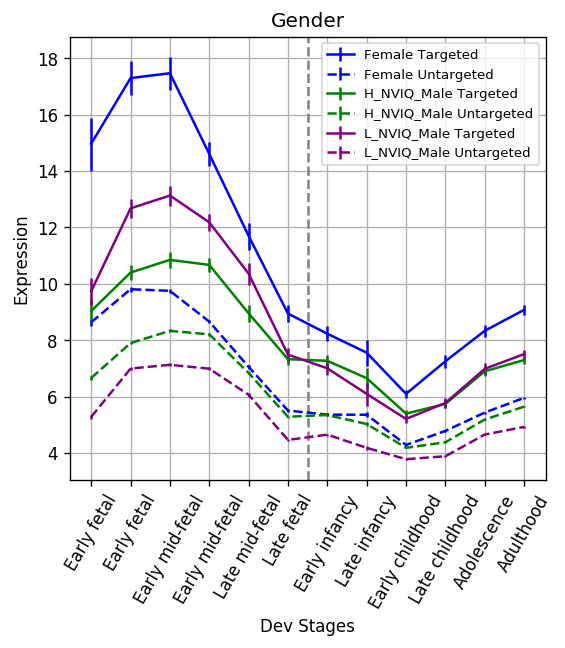

In [378]:
fig, ax = plt.subplots(dpi=120)
plt.title("Gender")
for cate in [Female, HIQ_Male, LIQ_Male]:
    Tseq, Terr, Useq, Uerr = cate.Reduce()
    #print Tseq
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

Female 1.04751050876 0.913243255822 0.134267252939 1.14702244126
H_NVIQ_Male 1.00499774325 0.996735660916 0.00826208233485 1.0082891409
L_NVIQ_Male 1.07138129818 0.892472987228 0.178908310948 1.20046355857


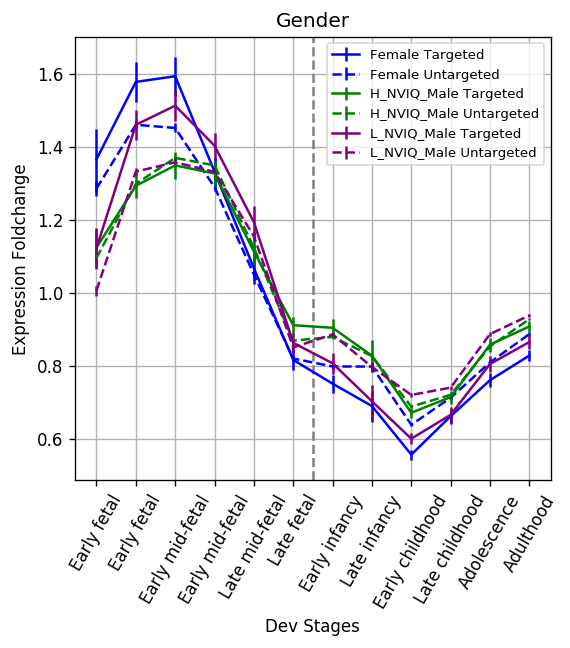

In [379]:
fig, ax = plt.subplots(dpi=120)
plt.title("Gender")
for cate in [Female, HIQ_Male, LIQ_Male]:
    Tseq, Terr, Useq, Uerr = cate.Reduce()
    Tseq_mean, Useq_mean = np.mean(Tseq), np.mean(Useq)
    Tseq = [x/Tseq_mean for x in Tseq]
    Useq = [x/Useq_mean for x in Useq]
    Terr = [x/Tseq_mean for x in Terr]
    Uerr = [x/Useq_mean for x in Uerr]
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=cate.GeneSetName+" Targeted", color=cate.GeneSetColor)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=cate.GeneSetName+" Untargeted", color=cate.GeneSetColor)
    pre, post, bias = Bias(Tseq, Useq)
    print cate.GeneSetName, pre, post, pre-post, bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle = '--')
plt.xticks(np.arange(2,14), ins.Descriptions, rotation=60)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
plt.xlabel("Dev Stages")
plt.ylabel("Expression Foldchange")
plt.show()

In [98]:
#display(bp_exon_row_meta_with_var.head())
Male_exons_df = bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pM", "pM;pM","pM;pF"])]
Male_exons = list(Male_exons_df["row_num"])
FeMale_exons = list(bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pF","pM;pF"])]["row_num"])
Male_genes = list(Male_exons_df["gene_symbol"])
FeMale_genes = list(bp_exon_row_meta_with_var[
    bp_exon_row_meta_with_var["Gender"].isin(["pF","pM;pF"])]["gene_symbol"])
Male_unTexons_df = bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(Male_genes)]
Male_unTexons = list(Male_unTexons_df["row_num"])
FeMale_unTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(FeMale_genes)]["row_num"])

MHNVIQ_exons_df = Male_exons_df[Male_exons_df["NVIQ70"]>70]
MLNVIQ_exons_df = Male_exons_df[Male_exons_df["NVIQ70"]<=70]
MHNVIQ_exons = list(MHNVIQ_exons_df["row_num"])
MLNVIQ_exons = list(MLNVIQ_exons_df["row_num"])

MHNVIQ_genes = MHNVIQ_exons_df["gene_symbol"]
MLNVIQ_genes = MLNVIQ_exons_df["gene_symbol"]

MHNVIQ_UTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(MHNVIQ_genes)]["row_num"])
MLNVIQ_UTexons = list(bp_exon_row_meta_without_var[
    bp_exon_row_meta_without_var["gene_symbol"].isin(MLNVIQ_genes)]["row_num"])

Male_FeMale = dict(zip(["MaleExons", "FemaleExons", "MaleGenesOtherExons", "FemaleGenesOtherExons", 
                        "HNVIQMaleExons", "HNVIQMale_Other_Exons", "LNVIQMaleExons", "LNVIQMale_Other_Exons"],
                       [Male_exons, FeMale_exons, Male_unTexons, FeMale_unTexons,
                       MHNVIQ_exons, MHNVIQ_UTexons, MLNVIQ_exons, MLNVIQ_UTexons]))
Male_FeMale = [("Female", "blue", FeMale_exons, FeMale_unTexons),
               ("Male", "red", Male_exons, Male_unTexons),
               ("Male High NVIQ", "pink", MHNVIQ_exons, MLNVIQ_UTexons),
               ("Male Low  NVIQ", "yellow", MLNVIQ_exons, MLNVIQ_UTexons)]

In [99]:
#display(MLNVIQ_exons_df)
genes1 = set(Male_exons_df["gene_symbol"])
exon1 = set(Male_exons_df["row_num"])
print set(Male.TargetedExon) == (exon1)

True


In [101]:
genes1 = LIQ_Male_genes
print genes1
exon1 = set(MLNVIQ_exons_df["gene_symbol"])
print exon1
print genes1 == (exon1)

set(['FOXP1', 'ADNP', 'GIGYF2', 'DIP2A', 'CASP8AP2', 'BCL11A', 'TBR1', 'JAKMIP1', 'DSCAM', 'ARHGAP5', 'ANKRD11', 'NEDD9', 'CHD8', 'AHDC1', 'RAI1', 'SCN2A', 'CDC42BPB', 'DYRK1A', 'PDCD1', 'ASH1L', 'INTS6', 'ATP1B1', 'SYNGAP1', 'DLL1', 'SUFU', 'TERF2', 'TANC2', 'MED13L', 'GRIN2B', 'KAT6A', 'WNT7B'])
set(['FOXP1', 'ADNP', 'GIGYF2', 'DIP2A', 'CASP8AP2', 'BCL11A', 'TBR1', 'JAKMIP1', 'DSCAM', 'ARHGAP5', 'ANKRD11', 'NEDD9', 'CHD8', 'AHDC1', 'RAI1', 'SCN2A', 'CDC42BPB', 'DYRK1A', 'PDCD1', 'ASH1L', 'INTS6', 'ATP1B1', 'SYNGAP1', 'DLL1', 'SUFU', 'TERF2', 'TANC2', 'MED13L', 'GRIN2B', 'KAT6A', 'WNT7B'])
True


In [327]:
SibNSYNVarFile = "/Users/jiayao/Work/BrainDisorders/data/DenovoVariants/wigler2014SibSYN.xlsx"
sibnsyn_annotated_exon_row_meta = ins.AssignVar2Exon3(bp_exon_row_meta, SibNSYNVarFile, IntersectionWithPredicted=False)
bp_exon_row_meta_sibnsyn_with_gene = sibnsyn_annotated_exon_row_meta[sibnsyn_annotated_exon_row_meta["GeneHited"]=="T"]
bp_exon_row_meta_sibnsyn_with_gene.to_excel("GenesExonsTargetedBySibSYN.xlsx", index=False)
bp_exon_row_meta_sibnsyn_with_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]!=""]
bp_exon_row_meta_sibnsyn_without_var = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["Vars"]==""]
print bp_exon_row_meta_sibnsyn_with_gene.shape, bp_exon_row_meta_sibnsyn_with_var.shape, bp_exon_row_meta_sibnsyn_without_var.shape

309222(8737, 15) (465, 15) (8272, 15)


In [345]:
sibsyn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
Genes = list(set(bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"].values))
SiblingSYN = GeneExonSet(sibsyn_expdict)
for i, gene in enumerate(Genes):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["exon length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["exon length"])
    SiblingSYN.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)

proband syn 4.09625803889 3.35719466505 0.739063373838


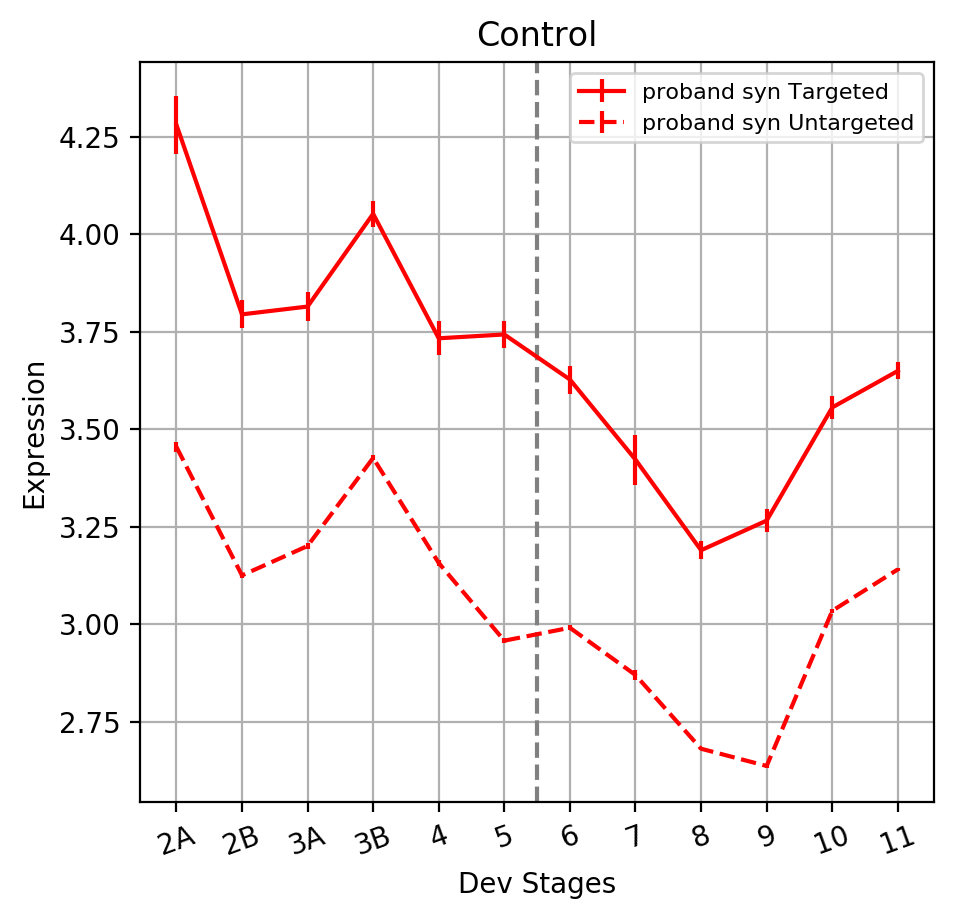

In [346]:
prosynDat = SiblingSYN.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()

[0.26399572999763965, 0.27048140938831322, 0.28074793821009569, 0.28590835172411921, 0.30347716201668673, 0.33837505400972834, 0.37456978634330484, 0.3799778813996082, 0.38280192067724217, 0.52150429150671762]
1
0.001


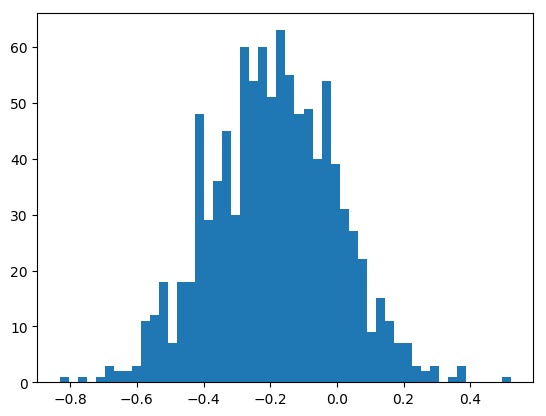

In [347]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingSYN.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

[-0.15642798444546724, -0.12264430548273042, -0.10684363446211886, -0.10216940933462393, -0.088436213709340628, -0.08487287057045112, -0.055122287536812919, -0.048588957447416981, 0.010337754878510186, 0.25037636296701837]
1
0.001


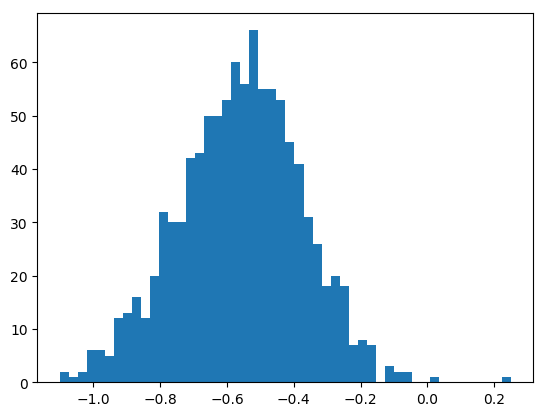

In [349]:
N = 1000
T = []
for i in xrange(N):
    bias, TE, UE = SiblingSYN.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()

In [ ]:
test = SiblingSYN.genes[:]
print len(test)
random.shuffle(test)
test = test[:100]
syn_expdict = ins.LoadGeneSetDataFromFil("SiblingSYN.Regionsgt20.GeneExonLog2Exp.csv")
SYN_test = GeneExonSet(syn_expdict)
for i, gene in enumerate(test):
    gene_df = bp_exon_row_meta_sibnsyn_with_gene[bp_exon_row_meta_sibnsyn_with_gene["gene_symbol"]==gene]
    TargetedExon = map(int, gene_df[gene_df["Vars"]!=""]["row_num"])
    UntargetedExon = map(int, gene_df[gene_df["Vars"]==""]["row_num"])
    TargetedExonL = map(int, gene_df[gene_df["Vars"]!=""]["cds length"])
    UntargetedExonL = map(int, gene_df[gene_df["Vars"]==""]["cds length"])
    probandSYN_test.addGene(gene, TargetedExon, UntargetedExon,TargetedExonL,UntargetedExonL)
prosynDat = probandSYN_test.Reduce()
fig, ax = plt.subplots(dpi=200)
plt.title("Control")
for title, color, Dat in [("proband syn", 'red', prosynDat)]:
    Tseq, Terr, Useq, Uerr = Dat
    ax.errorbar(range(2,14), Tseq, yerr = Terr, label=title+" Targeted", color=color)
    ax.errorbar(range(2,14), Useq, yerr = Uerr, linestyle = '--', label=title+" Untargeted", color=color)
    pre, post, O_bias = Bias(Tseq, Useq)
    #Dat.bias = bias
    print title, pre, post, O_bias
ax.grid(True)
ax.axvline(x=7.5, color="grey", linestyle="--")
plt.xticks(np.arange(2,14), Stages, rotation=20)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='upper right', fontsize=8)
#plt.ylim(2, 15)
plt.xlabel("Dev Stages")
plt.ylabel("Expression")
plt.show()
N = 100
T = []
for i in xrange(N):
    bias, TE, UE = probandSYN_test.Permute(plot=False)
    T.append(bias)
T_obs = O_bias
T.sort()
print T[-10:]
for i,t in enumerate(T):
    if T_obs <t:
        print i
        break
print N-i
print float(N-i)/N
plt.hist(T, 50)
plt.show()